<a href="https://colab.research.google.com/github/storimaging/Notebooks/blob/main/ImageGeneration/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Transfer with CNNs in PyTorch

## Introduction

This practical session explains how to implement the Neural style transfer based on the algorithm developed on [L. Gatys, A. Ecker and M. Bethge, "Image style transfer using convolutional neural networks", Proc. IEEE Conf. Comput. Vis. Pattern Recognit. (CVPR), pp. 2414-2423, Jun. 2016.](http://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Gatys_Image_Style_Transfer_CVPR_2016_paper.html). 

**Style transfer**: 

The algorithm allows you to take an image and reproduce it with a new artistic style. The algorithm takes three images, an input image, a content image, and a style image, and changes the input to resemble the content of the content-image and the artistic style of the style-image.

**References:**

This practical session is based on the original code of *Leon A. Gatys* and a reimplementation of deep-textures (similar algorithm) made by *Taras Savchyn*. Some explanations are also taken from the PyTorch tutorials.

*   Original code: https://github.com/leongatys/PytorchNeuralStyleTransfer
*   Reimplementation: https://github.com/trsvchn/deep-textures 
*   Tutorial used for some explanation: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

**Authors:**
* Lucía Bouza




## Underlying principle

We define two distances, one for content and one for style. The first measures the difference in content between two images while the second measures the difference in style between two images. Then, we take a third image, the input, and transform it to minimize both its content distance from the content image and its style distance from the style image.

$$
Loss(input) = StyleLoss(input) + ContentLoss(input)
$$

Let's call $v$ the content image. $ContentLoss$ is defined as MSE between $v$ and input, considering a set of layers $R$.

$$
ContentLoss(input) = \sum_{\text{for selected layers } R} w_L\left\| input - v \right\|^2_F
$$

Using the algorithm proposed by Gatys et al., $StyleLoss$ is defined as follows, calling $u$ to style image, and consdering a set of layers $L$.
$$
StyleLoss(input) = \sum_{\text{for selected layers } L} w_L\left\| G^L(input) - G^L(u) \right\|^2_F
$$

where $\|\cdot\|_F$ is the Frobenius norm and for an image $y$ and a layer index $L$ $G^L(y)$ denotes the Gram matrix of the VGG-19 features at layer $L$:
if $V^L(y)$ is the feature response of $y$ at layer $L$ that has spatial size $w\times h$ and $n$ channels, 
$$
G^L(y) = \frac{1}{w h}\sum_{k\in \{0,\dots,w-1\}\times\{0,\dots,h-1\}} V^L(y)_k V^L(y)_k^T \in \mathbb{R}^{n\times n}.
$$

The optimization is done using the L-BFGS algorithm.


## Exercise:

1. Go through the code and execute the algorithm.


## Importing packages

Below is a list of packages needed to implement style transfer. PyTorch version used to run this notebook is **1.11.0+cu113** (to check the installed version, use `torch.__version__`)

* `torch` (indispensable packages for neural networks with PyTorch)
* `torch.optim` (efficient gradient descent)
* `mse_loss` (to compute loss)
* `torchvision.models` (to get the vgg network)
* `torchvision.transforms.functional` (to transform images into tensors)
* `PIL.Image, matplotlib.pyplot` (to load and display images)
* `os` (to execute scripts with parameters into python code))

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn.functional import mse_loss
import torchvision.models as models
from torchvision.transforms.functional import resize, to_tensor, to_pil_image

from PIL import Image
import matplotlib.pyplot as plt
import os

## Loading images

In the next section we will load images. Here we'll just get, display, and save the image, without making any changes to it.


In [ ]:
styles_imgnames = ["desc.jpg", "Vincent_van_Gogh.jpg", "Gauguin.jpg"]
for fname in styles_imgnames:
    os.system("wget -c https://raw.githubusercontent.com/storimaging/Images/main/Styles/"+fname)
    img = Image.open(fname)

content_imgnames = ["ParisSunset.jpg", "MonetGarden3.jpg"]
for fname in content_imgnames:
    os.system("wget -c https://raw.githubusercontent.com/storimaging/Images/main/img/"+fname)
    img = Image.open(fname)

## Set a device

Next, we need to choose which device to run the algorithm on. Running the algorithm on large images takes longer and will go much faster when running on a GPU. We can use `torch.cuda.is_available()` to detect if there is a GPU available. Next, we set the `torch.device`. The `.to(device)` method is used to move tensors or modules to a desired device, we will use it in next sections. 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)
!nvidia-smi

Device is cuda
Tue May 31 13:33:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                         

## Data preparation

An important detail to note is that the neural network model we will use is trained on preprocessing images. We will need to apply the same preprocessing step to the image tensor before sending it into the network.

The preprocessing step consists only on subtracting the mean RGB value, computed on the training set (Imagenet), from each pixel. The original PIL images have values between 0 and 255, but when transformed into torch tensors, their values are converted to be between 0 and 1. Therefore, after subtracting the mean (`[0.485, 0.456, 0.406]`), it is necessary to multiply the tensor by 255 to the values be between 0 and 255 again. 
Read the following [paper](https://arxiv.org/pdf/1409.1556.pdf) on section 2.1 to learn more details about VGG training. 

Here are some helper functions for loading, displaying and transforming into tensors.

In [ ]:
#@title
# Utilities
# Functions to manage images

MEAN = (0.485, 0.456, 0.406)

# Based on Taras Savchyn's code
# https://github.com/trsvchn/deep-textures/blob/main/deeptextures/utils.py
def prep_img(image: str, size=None, mean=MEAN):
    """Preprocess image.
    1) load as PIl
    2) resize
    3) convert to tensor
    5) remove alpha channel if any
    4) substract mean and multipy by 255
    """
    im = Image.open(image)
    texture = resize(im, size)
    tensor = to_tensor(texture).unsqueeze(0)
    if tensor.shape[1]==4:
        print('removing alpha chanel')
        tensor = tensor[:,:3,:,:]
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device).view(-1, 1, 1)
    tensor.sub_(mean).mul_(255)
    return tensor

# Based on Taras Savchyn's code
# https://github.com/trsvchn/deep-textures/blob/main/deeptextures/utils.py
def denormalize(tensor: torch.Tensor, mean=MEAN):

    tensor = tensor.clone().squeeze() 
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device).view(-1, 1, 1)
    tensor.mul_(1./255).add_(mean)
    return tensor

# Taras Savchyn's code
# https://github.com/trsvchn/deep-textures/blob/main/deeptextures/utils.py
def to_pil(tensor: torch.Tensor):
    """Converts tensor to PIL Image.
    Args: tensor (torch.Temsor): input tensor to be converted to PIL Image of torch.Size([C, H, W]).
    Returns: PIL Image: converted img.
    """
    img = tensor.clone().detach().cpu()
    img = denormalize(img).clip(0, 1)
    img = to_pil_image(img)
    return img
    

def printResults(style_img, content_img, opt_img, iter, loss):
    """ Displays the intermediate results of the main iteration
    """ 
    print('Iteration: %d, loss: %f'%(iter, loss.item()))
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
    axes[0].imshow(to_pil(style_img.squeeze(0)))
    axes[0].set_title('Style image')
    axes[1].imshow(to_pil(content_img.squeeze(0)))
    axes[1].set_title('Content image')
    axes[2].imshow(to_pil(opt_img.squeeze(0)))
    axes[2].set_title('New Image')
    fig.tight_layout()
    plt.pause(0.05)

## Model

Now we need to define the neural network and import a pretrained model. We will use a 19-layer VGG network from PyTorch and the pretrained model used on the [paper](https://arxiv.org/abs/1505.07376). We use this particular model because it is a normalized version of the VGG network. Here, the weights are scaled such that the mean activation of each filter over training images and positions is equal to 1. The benefit of normalization is that losses based on features extracted from different layers of the network will have comparable magnitude. 
On this [github site](https://github.com/corleypc/vgg-normalize) you can find a detailed explanation of how  normalization works and an implementation to do it. Also [this thread](https://stats.stackexchange.com/questions/361723/weight-normalization-technique-used-in-image-style-transfer) can help to understand the process.  

VGG's PyTorch implementation is a module split into two sequential child modules: features (containing convolution and pooling layers) and classifier (containing fully connected layers). For the texture synthesis task, we are only interested in the layers of the features module. We won't let the parameters change: the network is already trained and used as an image transformation.

In [ ]:
!gdown 1lLSi8BXd_9EtudRbIwxvmTQ3Ms-Qh6C8

Downloading...
From: https://drive.google.com/uc?id=1lLSi8BXd_9EtudRbIwxvmTQ3Ms-Qh6C8
To: /content/vgg_conv.pth
100% 160M/160M [00:01<00:00, 90.5MB/s]


In [ ]:
cnn = models.vgg19(pretrained=False).features.to(device)
pretrained_dict = torch.load('vgg_conv.pth')

for param, item in zip(cnn.parameters(), pretrained_dict.keys()): 
    param.data = pretrained_dict[item].type(torch.FloatTensor).to(device)

cnn.requires_grad_(False)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

According to the algorithm explained at the beginning of this notebook, we need to access the outputs of some selected intermediate layers. In order to access the outputs of the layers on the PyTorch VGG19 network, we need to register a hook on each layer we need. Hooks are functions, which can be attached to each layer and called each time the layer is used. You can register a hook before or after the forward pass, or after the backward pass. We will define a function `save_output` that will be triggered after the forward pass, for each layer of the `features` module. 

The layer outputs will be stored in a dictionary where the key is the layer index and the value is the layer output tensor.

So we need to define which layers will be part of the optimization and define weights for each one (we will use the weights when performing the style transfer). Using the layer indices, we select the layers to use in the algorithm. We will choose indices [1, 6, 11, 20, 29] for style and index [22] for content. 

In [ ]:
# Initialize outputs dic
outputs = {}

# Hook definition
def save_output(name):
    
    # The hook signature
    def hook(module, module_in, module_out):
        outputs[name] = module_out
    return hook

# Define layers
style_layers = [1, 6, 11, 20, 29]
content_layers = [22]

# Define weights for layers
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1]

# Register hook on each layer with index on array "style_layers"
for layer in style_layers:
    handle = cnn[layer].register_forward_hook(save_output(layer))

# Register hook on each layer with index on array "content_layers"
for layer in content_layers:
    handle = cnn[layer].register_forward_hook(save_output(layer))

## Loss functions

We need to define the Loss function as explained at the beginning of the notebook. so we need to define style loss and content loss.

We define: 
* A function to calculate the Gram Matrix, 
* A gramm_loss function that computes the MSE for 2 Gram matrices: this will be style loss. 
* A content_loss function that computes the MSE for 2 (weighted) tensors: this will be the content loss.  

We will use L-BFGS algorithm to run gradient descent as suggested on paper. We will create a PyTorch L-BFGS optimizer `optim.LBFGS` and pass the `opt_imag` image to it as the tensor to optimize.


In [ ]:
# Computes Gram matrix for the input batch tensor.
#    Args: tnsr (torch.Tensor): input tensor of the Size([B, C, H, W]).
#    Returns:  G (torch.Tensor): output tensor of the Size([B, C, C]).
def gramm(tnsr: torch.Tensor) -> torch.Tensor: 
    
    b,c,h,w = tnsr.size() 
    F = tnsr.view(b, c, h*w)
    G = torch.bmm(F, F.transpose(1,2)) 
    G.div_(h*w)
    return G

# Computes MSE Loss for 2 Gram matrices 
def gram_loss(input: torch.Tensor, gramm_target: torch.Tensor, weight: float = 1.0):
    
    loss = weight * mse_loss(gramm(input), gramm_target)
    return loss

# Computes MSE Loss for 2 tensors, with weight
def content_loss(input: torch.Tensor, target: torch.Tensor, weight: float = 1.0):
    
    loss = weight * mse_loss(input, target)
    return loss

## Optimizer and initialization

In this section we choose our content and style images. These images are converted into tensors, performing normalization and resizing. 

Then we compute the activations of the layers selected for the style image (dictionary `outputs` after forward pass using style image). We also will compute Gram Matrix for those activations We will also compute Gram Matrix for these activations (these values doesn't change so is efficient calculate them only once).

We have also to compute the target activations of the selected layers for the content image (dictionary `outputs` after forward pass using content image).

In [ ]:
image_content = "ParisSunset.jpg"
image_style = "desc.jpg"
img_size = 512

# Prepare content and style data
content_im = prep_img(image_content, img_size).to(device)
style_im = prep_img(image_style, img_size).to(device)

# Forward pass using style image for get activations of selected layers. Calculate gram Matrix for those activations
cnn(style_im)
gramm_style_targets = [gramm(outputs[key]) for key in style_layers] 

# Forward pass using content image for get activations of selected layers. 
cnn(content_im)
target_content_im_activations = [outputs[key] for key in content_layers] 

We also define the image to optimize as a copy of the content image. This tensor needs to be optimized, so we set `requires_grad` to `True`.

We use L-BFGS algorithm to run gradient descent. We will create a PyTorch L-BFGS optimizer `optim.LBFGS` and pass the `opt_img` image to it as the tensor to optimize.

In [ ]:
# Define image to optimize as copy of content image
opt_img = content_im.clone()
opt_img.requires_grad_(True)

# Set optimizer
optimizer = optim.LBFGS([opt_img])

We are now able to perform style transfer. At each iteration of the network, it receives an updated input and computes new  Content and Style losses. 

* *Style Loss* will be gramm loss between `gramm_style_targets` and  activations for style layers `opt_img_style_im_activations`. 
* *Content Loss* will be MSE between `target_content_im_activations` and `opt_img_content_im_activations` (activations for content layers). 
* *Total Loss* will be the sum of the two. 

We will run the backward methods of each loss module to dynamically compute their gradients. The optimizer requires a “closure” function, which reevaluates the module and returns the loss.

Iteration: 0, loss: 76158704.000000


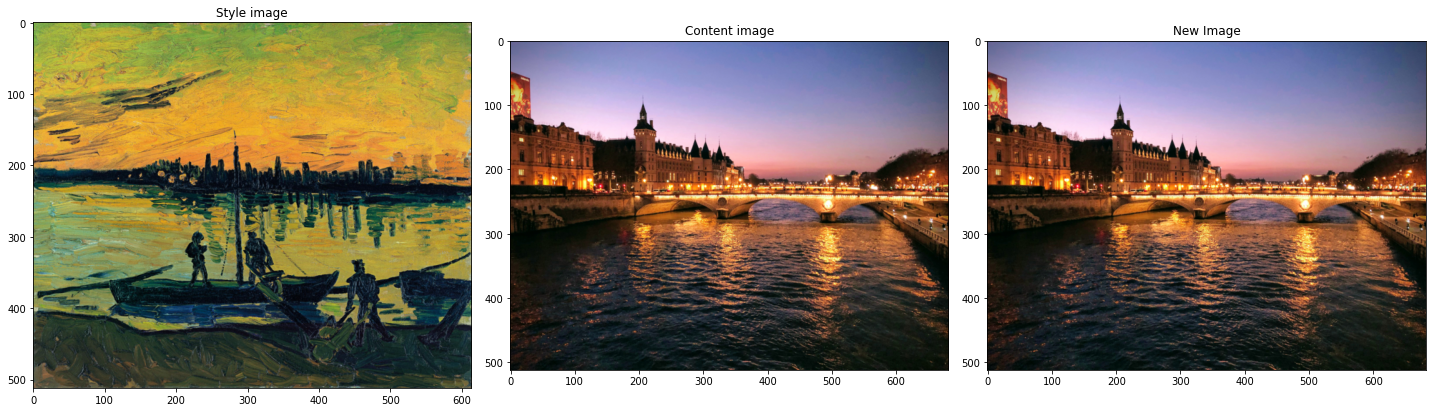

Iteration: 250, loss: 334859.187500


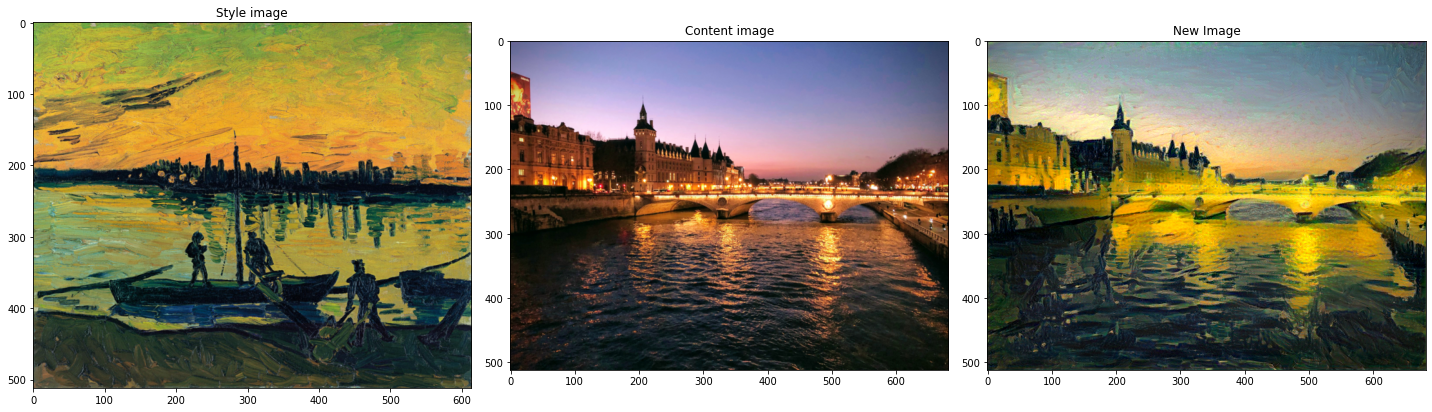

Iteration: 500, loss: 237221.531250


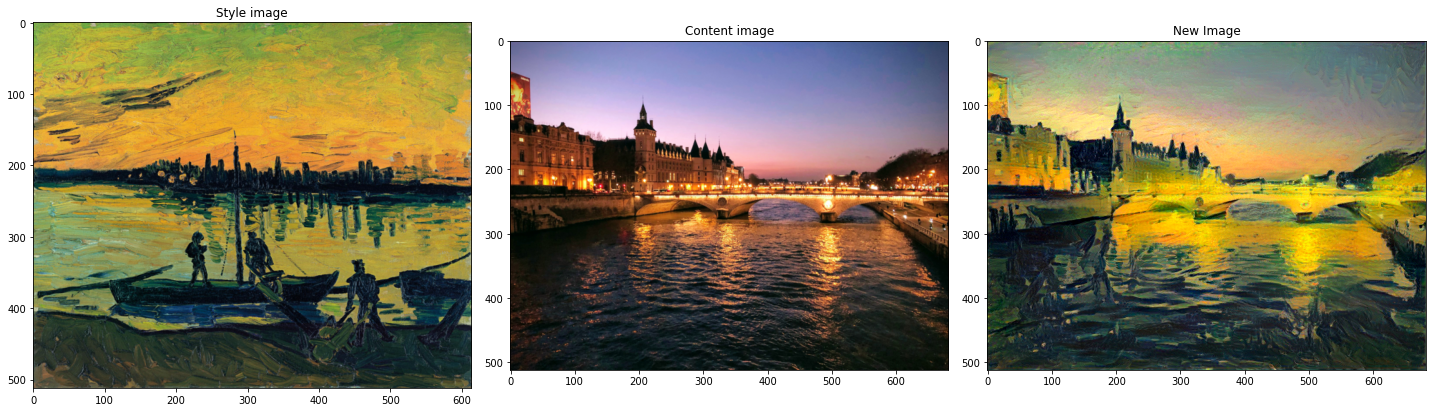

In [ ]:
# Inspired on Taras Savchyn's code
# https://github.com/trsvchn/deep-textures/blob/main/example.ipynb

n_iters = 500
log_every = 250
iter_ = 0

while iter_ <= n_iters:

    def closure():
        global iter_

        optimizer.zero_grad()

        # Forward pass using opt_img. Get activations of selected layers for image opt_img. Calculate gram Matrix for style activations
        cnn(opt_img)
        opt_img_style_im_activations = [outputs[key] for key in style_layers] 
        opt_img_content_im_activations = [outputs[key] for key in content_layers] 
  
        # Compute loss for each activation
        losses = []
        # Losses for style activations (mse loss with gram matrix)
        for activations in zip(opt_img_style_im_activations , gramm_style_targets, style_weights): 
            losses.append(gram_loss(*activations).unsqueeze(0))
        # Losses for content activations (mse loss)
        for activations in zip(opt_img_content_im_activations, target_content_im_activations, content_weights):
            losses.append(content_loss(*activations).unsqueeze(0))

        total_loss = torch.cat(losses).sum()
        total_loss.backward()

        # Display results: print Loss value and show images
        if iter_ % log_every == 0:
            printResults(style_im, content_im, opt_img, iter_, total_loss)

        iter_ += 1

        return total_loss

    optimizer.step(closure)